### 多分类逻辑回归

数据集：实现手写数字（0到9）的识别

### 1.1 数据集

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.io import loadmat
from sklearn.metrics import classification_report

In [3]:
data = loadmat('./datasets/ex3data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [4]:
data['X'].shape, data['y'].shape

((5000, 400), (5000, 1))

### 1.2 数据可视化

In [5]:
np.arange(data['X'].shape[0]).shape

(5000,)

In [6]:
# 从一维中随机抽取数字，并组成指定大小的数组
sample_idx = np.random.choice(np.arange(data['X'].shape[0]), 100)
sample_idx

array([3816, 2029,  134, 3300, 3659, 4367, 4138, 2990, 1353, 2717, 4592,
       2008, 1334, 1187,  581, 1639, 3890, 1728, 4988, 1445,  573,  304,
       3456, 4148,  451,  872, 2363, 1835, 2740,   26, 1291, 2301, 1421,
       2349, 4224, 4490, 3688,  174,  698, 4664, 3237, 3807, 3801, 4003,
       3191, 2439,  188, 3136, 2649, 4529, 2913, 3981, 4401, 2359, 2526,
       1702, 2753, 2948, 4692, 4896, 1655, 3967, 1840, 4207, 4447, 2135,
       3484, 1979, 2316, 4366, 2458, 2429, 1871, 4229, 4470, 2207, 3346,
       3789, 2291, 2370, 3854, 4838, 1598,  846,  939, 4789, 1759, 1958,
       4537, 2616, 1969, 3698, 1074, 4213, 1701, 2166, 3914, 2553, 2098,
       4148])

In [7]:
sample_images = data['X'][sample_idx, :]
sample_images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

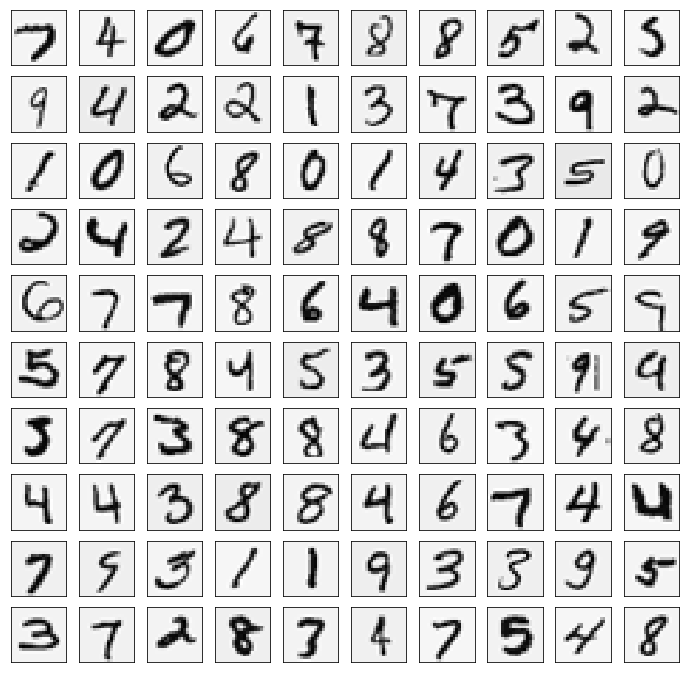

In [8]:
fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(12, 12))
for r in range(10):
    for c in range(10):
        ax_array[r, c].matshow(np.array(sample_images[10 * r + c].reshape((20, 20))).T,cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([])) 

### 1.3 将逻辑回归向量化

In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [10]:
def cost(theta, X, y, lr):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (lr / (2 * len(X))) * np.sum(np.power(theta[:, 1:theta.shape[1]], 2))
    
    return np.sum(first - second) / len(X) + reg

In [11]:
def gradient(theta, X, y, lr):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    error = sigmoid(X * theta.T) - y
    

    grad = ((X.T * error) / len(X)).T + ((lr / len(X)) * theta)
    grad[0, 0] = np.sum(np.multiply(error, X[:,0])) / len(X)
    
    return np.array(grad).ravel()

### 1.4 一对多分类器

  对于这个任务，我们有10个可能的类，并且由于逻辑回归只能一次在2个类之间进行分类，我们需要多类分类的策略。
  在本练习中，我们的任务是实现一对一全分类方法，其中具有k个不同类的标签就有k个分类器，每个分类器在“类别 i”和“不是 i”之间决定。

In [12]:
from scipy.optimize import minimize

def one_vs_all(X, y, num_labels, lr):
    rows = X.shape[0]
    params = X.shape[1]
    
#   多分类系数矩阵θ
    all_theta = np.zeros((num_labels, params + 1))
    
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    
    for i in range(1, num_labels + 1):
        theta = np.zeros(params + 1)
        
        y_i = np.array([1 if label == i else 0 for label in y])
        y_i = np.reshape(y_i, (rows, 1))
        
#       最小化每个分类器的代价函数

        fmin = minimize(fun=cost, x0=theta, args=(X, y_i, lr), method='TNC', jac=gradient)
        
        all_theta[i-1,:] = fmin.x
        
    return all_theta

In [13]:
# eg:
rows = data['X'].shape[0]
params = data['X'].shape[1]

all_theta = np.zeros((10, params + 1))

X = np.insert(data['X'], 0, values=np.ones(rows), axis=1)

theta = np.zeros(params + 1)

y_0 = np.array([1 if label == 0 else 0 for label in data['y']])
print(y_0.shape)
# y_0-->(rows, 1)
y_0 = np.reshape(y_0, (rows, 1))

X.shape, y_0.shape, theta.shape, all_theta.shape

(5000,)


((5000, 401), (5000, 1), (401,), (10, 401))

In [14]:
np.unique(data['y'])#看下有几类标签

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [15]:
# all_theta.shape(10, 401)
all_theta = one_vs_all(data['X'], data['y'], 10, 1)
all_theta

array([[-2.38291346e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.30474743e-03, -8.24531507e-10,  0.00000000e+00],
       [-3.18403111e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.46025411e-03, -5.08531235e-04,  0.00000000e+00],
       [-4.80012163e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.88116417e-05, -2.47992614e-07,  0.00000000e+00],
       ...,
       [-7.98722644e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.95295280e-05,  7.21832616e-06,  0.00000000e+00],
       [-4.57235036e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.33349450e-03,  9.96261157e-05,  0.00000000e+00],
       [-5.40509120e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16616386e-04,  7.88424336e-06,  0.00000000e+00]])

### 1.5 一对多预测

 使用训练完毕的分类器预测每个图像的标签。 对于这一步，我们将计算每个类的类概率，对于每个训练样本（使用当然的向量化代码），并将输出类标签为具有最高概率的类。

In [16]:
def predict_all(X, all_theta):
    rows = X.shape[0]
    params = X.shape[1]
    num_labels = all_theta.shape[0]
    
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    
    X = np.matrix(X)
    all_theta = np.matrix(all_theta)
    
    # compute the class probability for each class on each training instance
    h = sigmoid(X * all_theta.T)
    
    # create array of the index with the maximum probability
    h_argmax = np.argmax(h, axis=1)
    
    # because our array was zero-indexed we need to add one for the true label prediction
    h_argmax = h_argmax + 1
    
    return h_argmax 

In [17]:
y_pred = predict_all(data['X'], all_theta)
# classification_report函数用于显示主要分类指标的文本报告．在报告中显示每个类的精确度，召回率，F1值等信息
print(classification_report(data['y'], y_pred))

              precision    recall  f1-score   support

           1       0.95      0.99      0.97       500
           2       0.95      0.92      0.93       500
           3       0.95      0.91      0.93       500
           4       0.95      0.95      0.95       500
           5       0.92      0.92      0.92       500
           6       0.97      0.98      0.97       500
           7       0.95      0.95      0.95       500
           8       0.93      0.92      0.92       500
           9       0.92      0.92      0.92       500
          10       0.97      0.99      0.98       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



### 神经网络

实现识别手写数字的神经网络，在现有权重的基础上，实现前馈神经网络

In [19]:
weight = loadmat("./datasets/ex3weights.mat")
theta1, theta2 = weight['Theta1'], weight['Theta2']
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [20]:
# 插入常数项
X2 = np.matrix(np.insert(data['X'], 0, values=np.ones(X.shape[0]), axis=1))
y2 = np.matrix(data['y'])

X2.shape, y2.shape

((5000, 401), (5000, 1))

In [21]:
a1 = X2
z2 = a1 * theta1.T
z2.shape

(5000, 25)

In [22]:
a2 = sigmoid(z2)
a2.shape

(5000, 25)

In [23]:
a2 = np.insert(a2, 0, values=np.ones(a2.shape[0]), axis=1)
z3 = a2 * theta2.T
z3.shape

(5000, 10)

In [24]:
a3 = sigmoid(z3)
a3

matrix([[1.12661530e-04, 1.74127856e-03, 2.52696959e-03, ...,
         4.01468105e-04, 6.48072305e-03, 9.95734012e-01],
        [4.79026796e-04, 2.41495958e-03, 3.44755685e-03, ...,
         2.39107046e-03, 1.97025086e-03, 9.95696931e-01],
        [8.85702310e-05, 3.24266731e-03, 2.55419797e-02, ...,
         6.22892325e-02, 5.49803551e-03, 9.28008397e-01],
        ...,
        [5.17641791e-02, 3.81715020e-03, 2.96297510e-02, ...,
         2.15667361e-03, 6.49826950e-01, 2.42384687e-05],
        [8.30631310e-04, 6.22003774e-04, 3.14518512e-04, ...,
         1.19366192e-02, 9.71410499e-01, 2.06173648e-04],
        [4.81465717e-05, 4.58821829e-04, 2.15146201e-05, ...,
         5.73434571e-03, 6.96288990e-01, 8.18576980e-02]])

In [25]:
y_pred2 = np.argmax(a3, axis=1) + 1
y_pred2.shape

(5000, 1)

In [26]:
print(classification_report(y2, y_pred))

              precision    recall  f1-score   support

           1       0.95      0.99      0.97       500
           2       0.95      0.92      0.93       500
           3       0.95      0.91      0.93       500
           4       0.95      0.95      0.95       500
           5       0.92      0.92      0.92       500
           6       0.97      0.98      0.97       500
           7       0.95      0.95      0.95       500
           8       0.93      0.92      0.92       500
           9       0.92      0.92      0.92       500
          10       0.97      0.99      0.98       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000

